<a href="https://colab.research.google.com/github/NiccoloSalvi/naml/blob/main/matrix_completion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [157]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/NAML/lab3/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Matrix completion and recommender systems

[MovieLens](movielens.umn.edu) data sets were collected by the [GroupLens Research Project](http://www.grouplens.org/) at the University of Minnesota.

This data set consists of:
- 100000 ratings (1-5) from 943 users on 1682 movies.
- Each user has rated at least 20 movies.

The `movielens.csv` file contains the full dataset. Users and items are numbered consecutively from 1. The data is randomly              ordered. This is a tab separated list of

```
user id | item id | rating | timestamp
```

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr

Read the dataset from the `movielens.csv` file.

In [159]:
dataset = pd.read_csv('movielens.csv', sep = '\t', header = None)
dataset.describe()

,0,1,2,3
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


How many movies? How many people? How many ratings?

In [160]:
rows = np.array(dataset[0]) - 1
cols = np.array(dataset[1]) - 1
vals = np.array(dataset[2])

n = rows.max() + 1
p = cols.max() + 1
d = len(vals)

print(f'Number of movies: {p}')
print(f'Number of users: {n}')
print(f'Number of ratings: {d}')

Number of movies: 1682
Number of users: 943
Number of ratings: 100000


Shuffle the data (see the function [`np.random.shuffle`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html)).

In [161]:
idxs = np.arange(d)

np.random.seed(1)
np.random.shuffle(idxs)

rows = rows[idxs]
cols = cols[idxs]
vals = vals[idxs]

Split the dataset into a subset of 80000 training ratings and 20000 testing ratings.

In [162]:
training_data = 80000

rows_train = rows[:training_data]
cols_train = cols[:training_data]
vals_train = vals[:training_data]

print(rows_train[:10])
print(cols_train[:10])

rows_test = rows[training_data:]
cols_test = cols[training_data:]
vals_test = vals[training_data:]

rows_train.shape, rows_test.shape

[507 517 177 898 114  90   5 504 711 270]
[184 741  27 290 116 681 366 126  93 191]


((80000,), (20000,))

Let us denote by $\Omega$ the set of pairs $(i,j)$ such that rating of the $i$-th user on the $j$-th movie is available in the training set (similarly, $\Omega_{\text{test}}$ is the set of testing pairs).
Let us denote by $r_{ij}$ the corresponding rating.

Create a full matrix $X \in \mathbb{R}^{n \times p}$, such that:
$$
X_{i,j} =
\begin{cases}
r_{ij} & \text{if } (i,j) \in \Omega\\
0& \text{otherwise}
\end{cases}
$$

In [163]:
X_sparse = csr_matrix((vals_train, (rows_train, cols_train)), shape = (n, p))
X_full = X_sparse.toarray()
X_full.shape

(943, 1682)

## Trivial recommender system

Create a trivial recommender system, based on the average rating of each user:
$$
r^{\text{pred}}_{ij} = \frac{1}{N_i} \sum_{j : (i,j) \in \Omega} r_{ij}
$$
where $N_i = card(j : (i,j) \in \Omega)$.

Then compute the RMSE (root mean square error):
$$
\text{RMSE} = \sqrt{\frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}} (r_{ij} - r^{\text{pred}}_{ij})^2}
$$
and the Pearson correlation coefficient $\rho$ (use the function [scipy.stats.pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)):
$$
\rho =
\frac
{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}}
       (r_{ij} - \overline{r})
       (r^{\text{pred}}_{ij} - \overline{r}^{\text{pred}})
}
{\sqrt{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}}
       (r_{ij} - \overline{r})^2
       }
\sqrt{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}}
       (r^{\text{pred}}_{ij} - \overline{r}^{\text{pred}})^2
       }}
$$
where
$$
\begin{split}
\overline{r} &= \frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}}
       r_{ij}
\\
\overline{r}^{\text{pred}} &= \frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}}
       r^{\text{pred}}_{ij}
\end{split}
$$

### Trivial Recommender System Evaluation

In this section, we evaluate a **trivial recommender system** that predicts the ratings of each user based on their **average rating**. We use the **Root Mean Square Error (RMSE)** and the **Pearson correlation coefficient** to assess the performance of this simple model.

1. **Calculating Average Ratings per User:**
   
   We compute the average rating for each user using the training data. The following line of code calculates the average rating for every user:

   ```python
   avg_ratings = np.array([np.mean(vals_train[rows_train == i]) for i in range(n)])
   ```
   
   - `rows_train == i` creates a **boolean mask** that selects all ratings in the `vals_train` array corresponding to **User `i`**.
   - `np.mean(vals_train[rows_train == i])` calculates the **average rating** for the current user `i` using their ratings in the training set.
   - This produces an array `avg_ratings` of size `n` (number of users), where each element is the mean rating for a particular user.

2. **Predicting Test Ratings Using User Average:**

   We use the average rating of each user as the **predicted rating** for the test set:

   ```python
   vals_trivial = avg_ratings[rows_test]
   ```

   - `rows_test` contains the **user indices** for the ratings in the **test set**.
   - `avg_ratings[rows_test]` selects the average rating for each user in the test set, using their corresponding indices from `rows_test`.
   - This results in an array `vals_trivial` of predicted ratings based on the user averages.

3. **Calculating the Prediction Errors:**

   The prediction error for each rating in the test set is computed as:

   ```python
   errors_trivial = vals_test - vals_trivial
   ```

   - `vals_test` is the array of **actual ratings** from the test set.
   - `vals_trivial` is the array of **predicted ratings** using the trivial system.
   - The difference between `vals_test` and `vals_trivial` is stored in `errors_trivial`, representing the error for each prediction.

4. **Computing the Root Mean Square Error (RMSE):**

   The RMSE is a standard metric used to measure the accuracy of the predictions. It is defined as the square root of the **mean squared error**:

   ```python
   RMSE_trivial = np.sqrt(np.mean(errors_trivial ** 2))
   ```

   - `errors_trivial ** 2`: Squares each error value to eliminate negative signs.
   - `np.mean(...)`: Computes the mean of the squared errors.
   - `np.sqrt(...)`: Takes the square root of the mean squared error to obtain the RMSE.
   
   A **lower RMSE** indicates better performance, as it means the predictions are closer to the true ratings.

5. **Computing the Pearson Correlation Coefficient:**

   The Pearson correlation coefficient measures the **linear relationship** between the predicted ratings and the actual ratings:

   ```python
   rho_trivial = pearsonr(vals_test, vals_trivial)[0]
   ```

   - `pearsonr(vals_test, vals_trivial)` computes the Pearson correlation and returns a tuple: `(correlation_coefficient, p-value)`.
   - We extract the correlation coefficient (`rho_trivial`) to assess how strongly the predicted ratings are linearly correlated with the true ratings.
   
   The **Pearson correlation coefficient (`rho`)** ranges from `-1` to `1`:
   - `1`: Perfect positive correlation.
   - `0`: No linear correlation.
   - `-1`: Perfect negative correlation.
   
   A **higher `rho`** indicates that the trivial predictions are more linearly related to the true ratings.

6. **Summary of the Evaluation:**

   We use the RMSE and Pearson correlation coefficient to evaluate the trivial recommendation system. The results show how well the simple approach of using **user average ratings** works for predicting unseen ratings.

   ```python
   print(RMSE_trivial)
   print(rho_trivial)
   ```

   These values give us a baseline for comparison with more sophisticated recommendation systems, helping us understand the effectiveness of more advanced algorithms relative to this simple model.

In [164]:
# Initialize an array of zeros to store average ratings for each user
user_avg_ratings = np.zeros(n)  # n is the number of users, which is 942 in the MovieLens dataset

# Loop through each user and calculate the average rating
for i in range(n):
    user_i_ratings = X_sparse.getrow(i)  # Get the ratings of User i
    ratings = user_i_ratings.data        # Extract the non-zero ratings

    # Calculate N_i (number of non-zero ratings for User i)
    N_i = ratings.shape[0]  # or use user_i_ratings.getnnz()

    # Compute the average rating for User i and save it in the array
    if N_i > 0:  # Check to avoid division by zero
        user_avg_ratings[i] = np.sum(ratings) / N_i
    else:
        user_avg_ratings[i] = 0  # If no ratings, set the average to 0

# Print the average ratings array
# print("Average ratings for each user:", user_avg_ratings)

# professor's solutions
avg_ratings = np.array([np.mean(vals_train[rows_train == i]) for i in range(n)])
vals_trivial = avg_ratings[rows_test]

errors_trivial = vals_test - vals_trivial
RMSE_trivial = np.sqrt(np.mean(errors_trivial ** 2))
rho_trivial = pearsonr(vals_test, vals_trivial)[0]
print(RMSE_trivial)
print(rho_trivial)

1.0432310925295378
0.38352630698154627


# Singular value truncation (SVT) based recommender system

Implement the SVT algorithm to predict the ratings of the testing set. Set a maximum number of iterations equal to 100. Print the RMSE and $\rho$ at each iteration. Finally, plot the trend of both metrics.

Try to calibrate the threshold to get better results.

In [166]:
n_max_iter = 200
threshold = 150
increment_tol = 1e-6

RMSE_list = list()
rho_list = list()

A = X_full.copy()

for i in range(n_max_iter):
    A_old = A.copy()
    U, s, VT = np.linalg.svd(A, full_matrices = False)

    s[s < threshold] = 0
    A = U @ np.diag(s) @ VT

    A[rows_train, cols_train] = vals_train
    increment = np.linalg.norm(A - A_old)

    vals_predicted = A[rows_test, cols_test]
    errors = vals_test - vals_predicted

    RMSE_list.append(np.sqrt(np.mean(errors ** 2)))
    rho_list.append(pearsonr(vals_test, vals_trivial)[0])

    print('===== Iteration %d - Increment norm %1.3f' %(i+1, increment))
    print('RMSE %1.3f' %RMSE_list[-1])
    print('rho %1.3f' %rho_list[-1])

    if increment < increment_tol:
        break

===== Iteration 1 - Increment norm 414.609
RMSE 2.745
rho 0.384
===== Iteration 2 - Increment norm 264.404
RMSE 2.324
rho 0.384
===== Iteration 3 - Increment norm 195.681
RMSE 2.076
rho 0.384
===== Iteration 4 - Increment norm 155.920
RMSE 1.908
rho 0.384
===== Iteration 5 - Increment norm 129.725
RMSE 1.784
rho 0.384
===== Iteration 6 - Increment norm 111.061
RMSE 1.689
rho 0.384
===== Iteration 7 - Increment norm 97.053
RMSE 1.612
rho 0.384
===== Iteration 8 - Increment norm 86.141
RMSE 1.550
rho 0.384
===== Iteration 9 - Increment norm 77.398
RMSE 1.498
rho 0.384
===== Iteration 10 - Increment norm 70.236
RMSE 1.453
rho 0.384
===== Iteration 11 - Increment norm 64.264
RMSE 1.415
rho 0.384
===== Iteration 12 - Increment norm 59.209
RMSE 1.382
rho 0.384
===== Iteration 13 - Increment norm 54.876
RMSE 1.353
rho 0.384
===== Iteration 14 - Increment norm 51.121
RMSE 1.328
rho 0.384
===== Iteration 15 - Increment norm 47.838
RMSE 1.305
rho 0.384
===== Iteration 16 - Increment norm 44.942


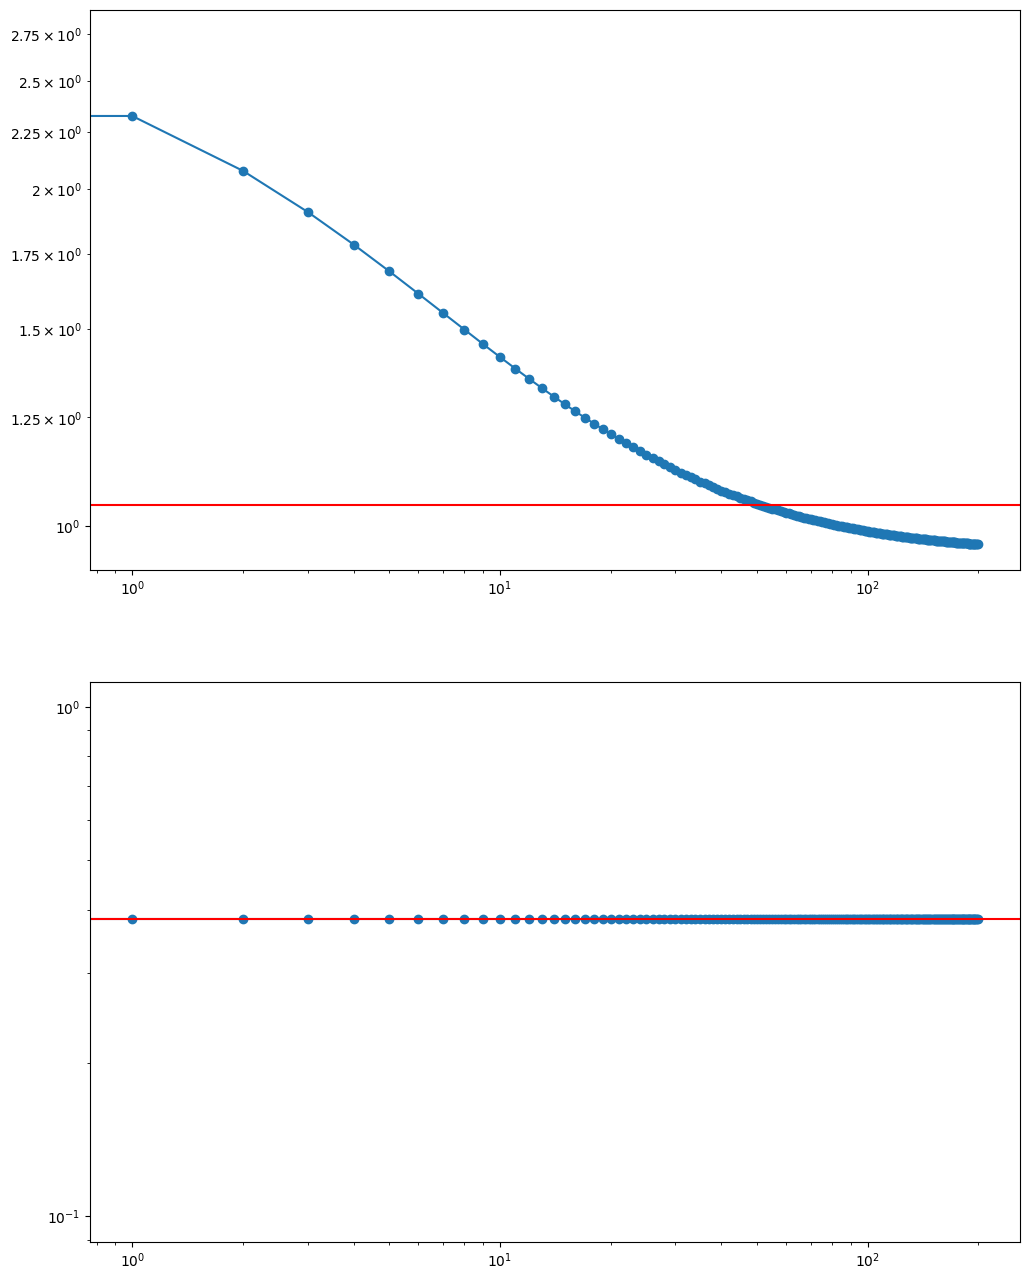

In [168]:
fig, axs = plt.subplots(2, 1, figsize=(12, 16))

axs[0].loglog(RMSE_list, 'o-')
axs[0].axhline(RMSE_trivial, color = 'red')

axs[1].loglog(rho_list, 'o-')
axs[1].axhline(rho_trivial, color = 'red')